# Preguntas

- Cual es el numero de tarea? The doc says proyecto 1

Proyecto 1 - Luis Eduardo Robles Jimenez

# Minería de Texto para Turismo

## Utils

In [269]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer

In [270]:
class TouristSpot:
    def __init__(self, path):
        self.reviews = pd.read_csv(path)
        self.spotName = path.split('/')[-1][: -4]
        self._cleanUp()
        self.nDashes = 30

    def _cleanUp(self):
        columns = ["Título de la opinión", "Opinión"]
        for col in columns:
            desc = []       
            for o in self.reviews.loc[:, col]:
                if o[0] == '"': o = o[1:]
                if o[-1] == '"': o = o[:-1]
                desc.append(o)
            self.reviews.loc[:, col] = desc

    def describe(self):
        nRows, nCols = 2, 1
        fig = plt.figure(figsize = (15, 10))
        fig.subplots_adjust(hspace=0.5)

        print(self.nDashes * '-', self.spotName, self.nDashes * '-')

        grades = fig.add_subplot(321)
        avg = np.round(np.average(self.reviews.loc[:, 'Escala']), decimals = 2)
        sd = np.round(np.std(self.reviews.loc[:, 'Escala']), decimals = 2)
        grades.hist(self.reviews.loc[:, 'Escala'])
        grades.set_title(f"Grades (1 worst; 5 best); Average = {avg}; SD = {sd}")

        length = fig.add_subplot(322)
        lenOpinions = [len(TweetTokenizer().tokenize(o)) for o in self.reviews.loc[:, 'Opinión']]
        avg = np.round(np.average(lenOpinions), decimals = 2)
        sd = np.round(np.std(lenOpinions), decimals = 2)
        length.hist(lenOpinions)
        length.set_title(f"Length of opinions (words); Average = {avg}; SD = {sd}")

        ages = fig.add_subplot(323)
        ages.hist(self.reviews.loc[:, 'Edad'])
        ages.set_title(f'Ages distribution')
        
        visitors = fig.add_subplot(324)
        visitors.hist(self.reviews.loc[:, 'Nacional ó Internacional'])
        visitors.set_title('Local or foreigner')
        
        languages = fig.add_subplot(325)
        languages.hist(self.reviews.loc[:, 'Idioma'], orientation = "horizontal")
        languages.set_title('Language')

        popularity = fig.add_subplot(326)
        popularity.hist([d[-4:] for d in self.reviews.loc[:, 'Fecha']])
        popularity.set_title('Popularity by year')
        
        plt.show()

## Actividades

### 1. Preprocesamiento y stats

In [271]:
path = "../../data/guanajuato/"

------------------------------ Teatro Juárez ------------------------------


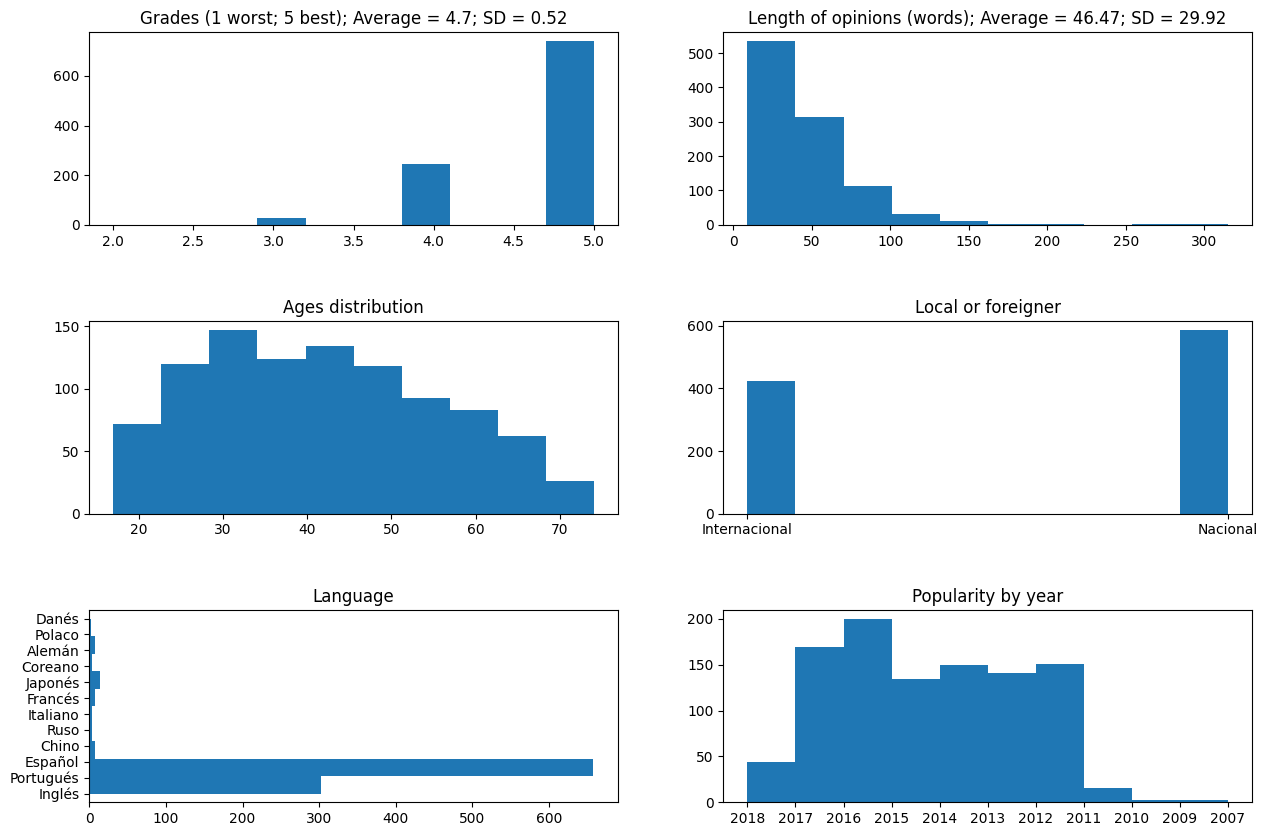

In [272]:
for d in os.listdir(path):
    spot = TouristSpot(os.path.join(path, d))
    spot.describe()
    break